In [1]:
#inspect_stock_data.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#23 January 2018
#
#this reads some NYSE data and makes some charts

In [2]:
#prep matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

In [3]:
#import numpy and pandas
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

In [4]:
#select date ranges, for plotting and for models
plot_date_range  = ('2016-02-01', '2016-10-01')
model_date_range = ('2017-01-12', '2018-01-12')

In [5]:
#read NYSE data
path = 'private/eoddata/NYSE_*.zip'
path = 'private/eoddata/NYSE_2016.zip'
data_date_range  = ('2016-01-10', '2017-01-01')
drop_holidays = True
from helper_fns import *
market = read_market_data(path, start_date=data_date_range[0], end_date=data_date_range[1],
    drop_holidays=drop_holidays)
print 'number of records (M) = ', len(market)/1.0e5
print 'number of tickers = ', len(market.ticker.unique())
print 'number of dates = ', len(market.date.unique())
print market.dtypes
market.head(6)

reading file =  private/eoddata/NYSE_2016.zip
number of records (M) =  6.90316
number of tickers =  2923
number of dates =  246
ticker            object
date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
vol                int64
dtype: object


,ticker,date,open,high,low,close,vol
0,A,2016-01-11,38.71,38.90,37.41,37.94,2818600
1,AA,2016-01-11,24.87,24.87,23.70,24.00,47942400
2,AAC,2016-01-11,18.25,18.36,17.21,17.46,98500
3,AAN,2016-01-11,20.40,20.69,20.34,20.55,653200
4,AAP,2016-01-11,146.13,148.12,145.06,147.05,1114300
5,AAT,2016-01-11,37.70,38.05,37.55,37.81,142900


In [6]:
#compute cumulative-sum of dollar-volume traded each day
N_days = (market.date.max() - market.date.min()).days
market['dollar_rate'] = market['open']*market['vol']/N_days
giga_dollars_per_day_cs = market.groupby('ticker')['dollar_rate'].sum().sort_values(ascending=False).cumsum()/1.0e9
giga_dollars_per_day_cs.head(5)

ticker
BAC     1.160481
BABA    2.034284
WFC     2.812188
JPM     3.580230
GE      4.313617
Name: dollar_rate, dtype: float64

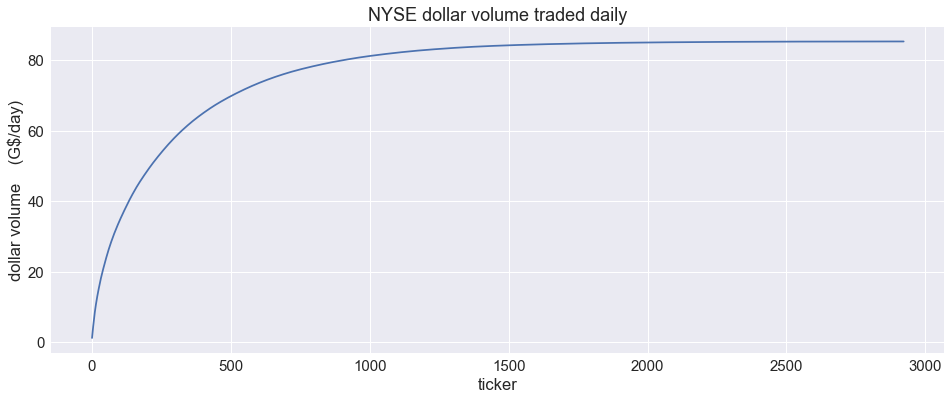

In [7]:
#plot giga_dollars_per_day_cs versus ticker
yp = giga_dollars_per_day_cs
xp = range(len(yp))
fig, ax = plt.subplots(figsize=(16, 6))
p = ax.plot(xp, yp, linestyle='-')
p = ax.set_title('NYSE dollar volume traded daily')
p = ax.set_xlabel('ticker')
p = ax.set_ylabel('dollar volume    (G$/day)')
#plt.savefig('figs/volume.png')

In [8]:
#get top 50 tickers by traded dollar value
N_tickers = 5#0#0
tickers = giga_dollars_per_day_cs.index[0:N_tickers].values.tolist()
print tickers

['BAC', 'BABA', 'WFC', 'JPM', 'GE']


In [9]:
#resample across 1-week time-bins, pivot data, and lag 'close' column by 1 week
freq = 'w'
market_resampled, dfr = resample_data(market, freq, tickers=tickers)
print 'market_resampled.shape = ', market_resampled.shape
print 'market_resampled.columns = ', market_resampled.columns
market_resampled.head()
#dfr.head()
#dfr.tail()

market_resampled.shape =  (50, 20)
market_resampled.columns =  Index([u'close_BABA', u'close_BAC', u'close_GE', u'close_JPM', u'close_WFC',
       u'G$vol_BABA', u'G$vol_BAC', u'G$vol_GE', u'G$vol_JPM', u'G$vol_WFC',
       u'std_BABA', u'std_BAC', u'std_GE', u'std_JPM', u'std_WFC',
       u'delta_BABA', u'delta_BAC', u'delta_GE', u'delta_JPM', u'delta_WFC'],
      dtype='object')


,close_BABA,close_BAC,close_GE,close_JPM,close_WFC,G$vol_BABA,G$vol_BAC,G$vol_GE,G$vol_JPM,G$vol_WFC,std_BABA,std_BAC,std_GE,std_JPM,std_WFC,delta_BABA,delta_BAC,delta_GE,delta_JPM,delta_WFC
date,,,,,,,,,,,,,,,,,,,,
2016-01-19,69.59,14.46,28.49,57.04,48.82,5.747926,9.370900,8.450310,8.282360,6.795101,0.021231,0.029906,0.011051,0.021242,0.023086,-0.023846,-0.052425,-0.001752,-0.030427,-0.027102
2016-01-25,70.37,13.56,28.24,56.95,49.02,4.865765,11.087047,8.037661,6.272410,5.439083,0.031120,0.033846,0.012722,0.016729,0.018575,-0.021824,-0.076923,-0.016713,-0.013511,-0.004670
2016-02-01,67.03,14.14,29.10,59.50,50.23,7.261738,9.479906,6.360318,5.797856,5.332100,0.024653,0.019241,0.005139,0.014129,0.012972,-0.053249,0.044313,0.027542,0.053470,0.026988
2016-02-08,62.64,12.95,28.54,57.75,47.86,6.761087,10.917212,6.712196,6.627533,7.026365,0.017326,0.031896,0.013148,0.014581,0.020454,-0.058045,-0.078292,-0.016201,-0.023834,-0.045092
2016-02-16,60.89,11.95,28.26,57.49,47.31,4.048509,15.711884,7.131266,8.772505,6.539135,0.012129,0.043001,0.012174,0.019949,0.019155,-0.000164,-0.056827,0.001417,0.014112,0.004245


In [ ]:
#get x=model features and y=target variables
cols = ['close', 'G$vol', 'std']
df = pd.DataFrame
for col in cols:
    x = x.append(market_resampled[col], axis=0)

In [ ]:
df = market_resampled
cols = [col[0]+'_'+col[1] for col in market_resampled.columns.tolist()]
df.columns = cols
df.head()

In [ ]:
ticker = 'GE'
df = market_resampled
idx = (df['ticker'] == ticker)
df = df[idx]
df.head()

In [ ]:
ticker = 'GE'
df = market
idx = (df['ticker'] == ticker)
df = df[idx].set_index('date')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
yp = df['open']
ax.plot(yp, marker='o', markersize=3, linestyle='-', label='open')
yp = df['close']
ax.plot(yp, marker='o', markersize=3, linestyle='-', label='close')
df = market_resampled
idx = (df['ticker'] == ticker)
df = df[idx].set_index('date')
yp = df['open']
xp = yp.index
err = df['std']
ax.errorbar(xp, yp, yerr=err, marker='o', markersize=9, linestyle='-.', alpha=0.6, label='weekly avg')
df = df.set_index('date_lagged')
yp = df['open']
xp = yp.index
ax.plot(yp, marker='o', markersize=9, linestyle='-.', label='open/lagged')
ax.set_title('ticker = ' + ticker)
ax.set_ylabel('share price')
ax.set_xlabel('date')
ax.set_xlim(plot_date_range)
ax.legend()
#plt.savefig('figs/field_parameters.png')

In [ ]:
market_resampled.head()

In [ ]:
#compute volume of shares traded each day
daily_volume = market.groupby('date')['vol'].sum()
daily_volume.head(10)

In [ ]:
#plot daily volume vs date
fig, ax = plt.subplots(figsize=(16, 6))
xp = daily_volume.index
yp = daily_volume.values/1.0e9
p = ax.plot(xp, yp, linestyle='-')
ax.set_title('NYSE daily share volume')
ax.set_xlabel('date')
ax.set_ylabel('shares traded    (G)')
ax.set_ylim(0, 8)
ax.set_xlim(plot_date_range)
plt.savefig('figs/volume.png')

In [ ]:
#compute volume-weighted share price versus date
def volume_weighted_share_price(record):
    vwsp = None
    cv = record['close']*record['vol']
    v_total = record['vol'].sum()
    if (v_total > 0.0):
        vwsp = cv.sum()/v_total
    return vwsp
vwsp = market.groupby('date').apply(volume_weighted_share_price)

In [ ]:
#plot volume-weighted share price vs date
fig, ax = plt.subplots(figsize=(16, 6))
xp = vwsp.index
yp = vwsp.values
p = ax.plot(xp, yp, linestyle='-')
ax.set_title('NYSE volume-weighted mean share price')
ax.set_xlabel('date')
ax.set_ylabel('volume-weighted share price')
ax.set_ylim(31, 45)
ax.set_xlim(plot_date_range)
plt.savefig('figs/vwsp.png')

In [ ]:
#plot fractional volume-weighted gain vs date
fig, ax = plt.subplots(figsize=(16, 6))
xp = vwsp.index
yp = vwsp.values
yp = (yp - yp[0])/yp[0]
p = ax.plot(xp, yp, linestyle='-')
p = ax.set_title('fractional change in NYSE volume-weighted mean share price')
p = ax.set_xlabel('date')
p = ax.set_ylabel('fractional gain')
p = ax.set_xlim(plot_date_range)
plt.savefig('figs/fractional_vwsp.png')

In [ ]:
#simulate mean outcome for 25 people, each trading $10K worth of randomly selected tickers daily
N_buyers = 25
N_tickers = 5
initial_dollars = 10000.0
idx = (market['date'] >= model_date_range[0]) & (market['date'] <= model_date_range[1])
market_data = market[idx]
ran_purchases = random_purchases(market_data, N_buyers, N_tickers, initial_dollars)

In [ ]:
#plot mean fractional gain exhibited by random purchasers
fig, ax = plt.subplots(figsize=(16, 6))
xp = ran_purchases.index.values
yp = ran_purchases['dollars_mean'].values
err = ran_purchases['dollars_std'].values/yp[0]
yp = (yp -yp[0])/yp[0]
p = ax.plot(xp, yp, linestyle='-')
p = ax.errorbar(xp, yp, err, linestyle='none', alpha=0.5)
ax.set_title('simulated outcome for daily random purchases')
ax.set_xlabel('date')
ax.set_ylabel('fractional gain')
ax.set_xlim(model_date_range)
plt.savefig('figs/random_purchases.png')